In [ ]:
import pandas as pd
import urllib
import pickle
import rassp
from rassp import netutil
from rdkit import Chem
import numpy as np
import torch
import matchms
import matplotlib.pyplot as plt

In [ ]:
from rassp import msutil,model
import sys
sys.modules['msutil'] = msutil
sys.modules['model'] = model

In [ ]:
base='https://people.cs.uchicago.edu/~ericj/rassp/'
files=[ 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model',    
'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta',
#'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.00001000.model', 
#'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.meta',   
#'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.00000480.model',
#'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.meta'
]

for f in files:
    urllib.request.urlretrieve(f'{base}/{f}',f)

In [ ]:
from rassp.msutil.masscompute import FragmentFormulaPeakEnumerator

#valid_atoms = {1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53}
valid_atoms = {1, 6, 7, 8, 9, 15, 16, 17}
num_peaks_per_formula = 12
#max_formulae = 100000
max_formulae = 4096

ffe = FragmentFormulaPeakEnumerator(sorted(valid_atoms), use_highres=True, max_peak_num=num_peaks_per_formula)

def goodmol(mol):
        if len(mol.GetAtoms()) > 48:
            return False
        
        atoms = { a.GetAtomicNum() for a in mol.GetAtoms() }
        if not atoms < valid_atoms:
            return False
            
        f,m = ffe.get_frag_formulae(mol)
        if len(f) > max_formulae:
            return False

        return True


In [ ]:
test = pd.read_parquet('test.pq')
test

In [ ]:
smalltest = test[[ goodmol(Chem.AddHs(Chem.Mol(m))) for m in test.rdmol ]]
smalltest

In [ ]:
use_gpu=True
model='formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model'
meta='formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta'

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

predictor = netutil.PredModel(
    meta,
    model,
    USE_CUDA=use_gpu,
    data_parallel=False,
)


In [ ]:
#sample = smalltest.sample(1000)
sample = smalltest

mols = [ Chem.AddHs(Chem.Mol(m)) for m in sample.rdmol ]

predictions = predictor.pred(
    mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=1, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)


In [ ]:
pred = predictions['pred_binned']
true = [ np.stack(list(t)) for t in sample.spect ]

In [ ]:
def to_matchms_spec(s):
    return matchms.Spectrum(mz=s[:,0].astype(float),intensities=s[:,1].astype(float))

In [93]:
matchms.set_matchms_logger_level("ERROR")

#sim = matchms.similarity.CosineGreedy()
# SDP
# sim = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)

# normal DP
sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(len(true)) ]
dp = np.array([ float(s['score']) for s in dp ])

sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)
sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(len(true)) ]
sdp = np.array([ float(s['score']) for s in sdp ])


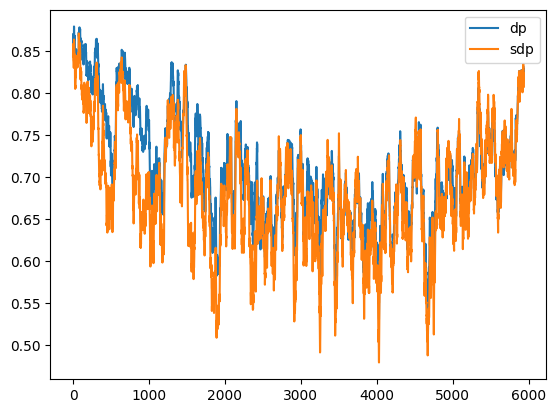

In [94]:
win = 50
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='dp')
plt.plot(smooth_sdp,label='sdp')
plt.legend()
#plt.plot([ float(s['matches']) for s in scores ])
plt.show()

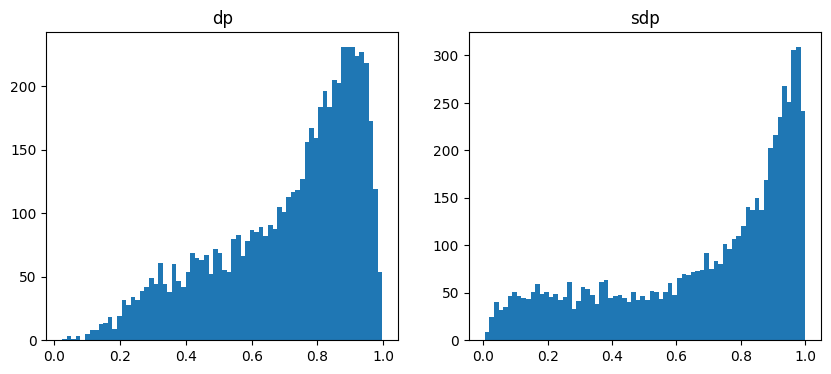

In [95]:
bins = 70
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(dp,label='dp',bins=bins)
plt.title('dp')
plt.subplot(122)
plt.hist(sdp,label='sdp',bins=bins)
plt.title('sdp')
#lt.legend()
plt.show()

In [96]:
np.mean(dp),np.std(dp)

(0.7112892446164145, 0.21426279709018384)

In [97]:
np.mean(sdp),np.std(sdp)

(0.6826941299444842, 0.28348170077575846)